In [1]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

True

In [2]:
!pip install ../forks/tensortrade_source/ -U

Processing c:\users\codeninja\dev\forks\tensortrade_source
  Created wheel for tensortrade: filename=tensortrade-0.1.0rc1-cp37-none-any.whl size=73691 sha256=6470c269a352c61029163d859e9b498542ca8dde91a8dca94232c328a2f37ea4
  Stored in directory: C:\Users\CODENI~1\AppData\Local\Temp\pip-ephem-wheel-cache-4rq7y7iq\wheels\62\be\3a\90782c795f0ba93fec4a55c551ac7e8f7e7ea933797e4f71c0
Successfully built tensortrade
  Found existing installation: tensortrade 0.1.0rc1
    Uninstalling tensortrade-0.1.0rc1:
      Successfully uninstalled tensortrade-0.1.0rc1


In [3]:
import os
import sys
import warnings
import numpy
import ccxt
import pandas as pd
import numpy as np
from time import time
import math
import cProfile as cp
import matplotlib.pyplot as plt
import pickle

from gym.spaces import Space, Box

config = './neat.config'

def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.simplefilter(action='ignore', category=FutureWarning)
numpy.seterr(divide = 'ignore') 

sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.abspath('')+"\\tensortrade")


**Load Data**

In [4]:

data_file ='./data/processed/binance/btc_usdt_1h.csv' 
df = pd.read_csv(data_file, index_col=[0])


# number of days we want to pull from the dataframe 
days_of_data = 365

# number of data frames (our DF is in 1h timesteps)
frames = days_of_data * 24 * 5
# frames = len(df)
train_test_percentage = 0.4

x_train = int(frames * (1 - train_test_percentage))
x_test = int(frames - x_train)

df_train = df[-frames:(-x_test - 1)]
df_test = df[-x_test:]
print("Friend Shape", df.shape)
print('train shape', df_train.shape)
print('test shape', df_test.shape)
print('columns', df.columns)

Friend Shape (180236, 12)
train shape (26279, 12)
test shape (17520, 12)
columns Index(['open', 'high', 'low', 'close', 'volume', 'momentum_rsi', 'adx',
       'adx_long', 'adx_pos', 'adx_neg', 'trend_ema_fast', 'trend_ema_slow'],
      dtype='object')


In [5]:
df_test.head()

,open,high,low,close,volume,momentum_rsi,adx,adx_long,adx_pos,adx_neg,trend_ema_fast,trend_ema_slow
index,,,,,,,,,,,,
2019-08-28 03:35:00,10148.20,10155.65,10140.00,10140.49,103.707956,34.890237,19.680116,9.632237,15.942283,24.099556,10153.780045,10155.268113
2019-08-28 03:40:00,10140.74,10148.78,10125.01,10133.83,73.728054,30.560787,19.729527,9.551850,14.434463,27.784685,10150.710807,10153.680105
2019-08-28 03:45:00,10135.11,10145.87,10120.00,10120.01,102.866752,23.560759,20.578936,9.524416,12.994025,26.944578,10145.987606,10151.186023
2019-08-28 03:50:00,10120.02,10133.51,10116.34,10120.03,55.034065,23.589984,21.604012,9.514225,12.128909,26.569855,10141.994128,10148.878170
2019-08-28 03:55:00,10120.03,10130.00,10119.02,10126.17,48.912488,32.704088,22.726318,9.516439,11.597170,25.405014,10139.559647,10147.196083


**Load Previous Winner**

In [6]:
# winner = "winner-1751.bin"
# with open("winners/{}".format(winner), "rb") as f:
#     winner = pickle.load(f)

**Train against training data**

In [ ]:
import tensortrade
from neat_trading_strategy import NeatTradingStrategy as TradingStrategy
from neat_reward_strategy import NeatRewardStrategy as ProfitStrategy
from tensortrade.actions import DiscreteActions
from tensortrade.exchanges.simulated import SimulatedExchange as Exchange
from tensortrade.features.scalers import MinMaxNormalizer
from tensortrade.features import FeaturePipeline
from tensortrade.environments import TradingEnvironment as Environment

print('fin imports')
normalize = MinMaxNormalizer(inplace=True)
feature_pipeline = FeaturePipeline(steps=[normalize])

reward_scheme = ProfitStrategy()
action_scheme = DiscreteActions(n_actions=5, instrument='BTC/USDT')
print('fin strats')

exchange = Exchange(data_frame=df_train,
                    pretransform = True,
                    base_instrument='USDT', 
                    commission_percent=0.075,
                    window_size=1,
                    max_allowed_slippage_percent=3.0,
                    min_order_amount=1E-4,
                    min_trade_amount=1E-4,
                    observation_columns = df_train.columns
                   )
print('fin exchange')

environment = Environment(exchange=exchange,
                                 action_scheme=action_scheme,
                                 reward_scheme=reward_scheme,
                                 feature_pipeline=feature_pipeline)
print('fin environment')
print('')

segments_in_day = 288
days = 2

strategy = TradingStrategy(environment=environment,
                           pop_size= 50,
                           initial_connectin='full_nodirect',
                           max_stagnation= 10,
                           neat_config=config, 
                           watch_genome_evaluation=False,
                           only_show_profitable=False,
                           data_frame_window = segments_in_day * days
                          )

print("Running through ", strategy._data_frame_window, ' steps')
# cp.run("performance, winner, stats = strategy.run(generations=20)", 'evolution_stats')
performance, winner, stats = strategy.run(generations=50)

fin imports
fin strats
fin exchange
fin environment

Running through  576  steps

 ****** Running generation 0 ****** 

Population's average fitness: 30.06173 stdev: 199.82697
Best fitness: 1428.77276 - size: (13, 181) - species 2 - id 17
Average adjusted fitness: 0.029
Mean genetic distance 4.286, standard deviation 0.560
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    12      6.7    0.001     0
     2    0    38   1428.8    0.057     0
Total extinctions: 0
Generation time: 28.353 sec

 ****** Running generation 1 ****** 

Population's average fitness: 119.09814 stdev: 394.86918
Best fitness: 1523.06959 - size: (13, 175) - species 2 - id 79
Average adjusted fitness: 0.078
Mean genetic distance 4.168, standard deviation 0.627
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    21   1406.5    0.079     0
     2   

**Evaluate against full dataset**

In [61]:
 _test_data = df_test[-280*14:(-280*13)]
exchange = Exchange(data_frame=_test_data,
                    pretransform = True,
                    base_instrument='USDT', 
                    commission_percent=0.075,
                    window_size=1,
                    max_allowed_slippage_percent=3.0,
                    min_order_amount=1E-4,
                    min_trade_amount=1E-4,
                    observation_columns = df_test.columns
                   )
environment = Environment(exchange=exchange,
                                 action_scheme=action_scheme,
                                 reward_scheme=reward_scheme,
                                 feature_pipeline=feature_pipeline)

environment.reset()
# from neat_trading_strategy import NeatTradingStrategy as TradingStrategy
# exchange.balance = 100000
strategy = strategy = TradingStrategy(environment=environment, 
                           neat_config=config, 
                           watch_genome_evaluation=True,
                           only_show_profitable=False,
                           full_evaluation=True
                          )
# TradingStrategy(environment=environment, watch_genome_evaluation=True, full_evaluation = True, neat_config=config)

In [62]:
exchange._balance = 100
print("Starting Worth: {}".format(exchange.net_worth, exchange.balance))
strategy.eval_genome(winner, strategy._config)

Starting Worth: 100
Empty DataFrame
Columns: [step, symbol, type, amount, price]
Index: []
---------------------------
-------WE DONE!---------
Genome ID:  8
Rewards: 229.54331159290962
Balance: 162.73000000000013
Net Worth: 162.73000000000013
Steps Completed 278
Most common action dict_items([('MARKET_BUY', 139), ('LIMIT_SELL', 139)])
Number of trades: Counter({<TradeType.MARKET_BUY: 2>: 110, <TradeType.LIMIT_SELL: 3>: 110})


229.54331159290962

In [63]:
pd.set_option('display.max_colwidth', -1)

In [64]:
exchange.performance.tail()

,balance,net_worth,action,step
215,161.32,161.320000,bdb942d4-0b51-11ea-974e-d8cb8a39e9e7: TradeType.LIMIT_SELL 0.01852428 units of BTC for 8303.42 each. Total:153.93 Comission:0.12@0.00075%,272
216,0.23,158.323587,bdbaf088-0b51-11ea-9987-d8cb8a39e9e7: TradeType.MARKET_BUY 0.01904703 units of BTC for 8450.97 each. Total:161.09 Comission:0.12@0.00075,273
217,158.67,158.670000,bdbc771e-0b51-11ea-8c0d-d8cb8a39e9e7: TradeType.LIMIT_SELL 0.01904703 units of BTC for 8312.02 each. Total:158.44 Comission:0.12@0.00075%,274
218,6.99,162.486637,bdbdfdc6-0b51-11ea-bf61-d8cb8a39e9e7: TradeType.MARKET_BUY 0.01871199 units of BTC for 8099.74 each. Total:151.68 Comission:0.11@0.00075,275
219,162.73,162.730000,bdbfab7a-0b51-11ea-aa54-d8cb8a39e9e7: TradeType.LIMIT_SELL 0.01871199 units of BTC for 8316.55 each. Total:155.74 Comission:0.12@0.00075%,276


In [65]:
exchange.trades.tail()

,step,symbol,type,amount,price,index
215,272,BTC,TradeType.LIMIT_SELL,0.018524,153.93,open
216,273,BTC,TradeType.MARKET_BUY,0.019047,161.09,open
217,274,BTC,TradeType.LIMIT_SELL,0.019047,158.44,open
218,275,BTC,TradeType.MARKET_BUY,0.018712,151.68,open
219,276,BTC,TradeType.LIMIT_SELL,0.018712,155.74,open


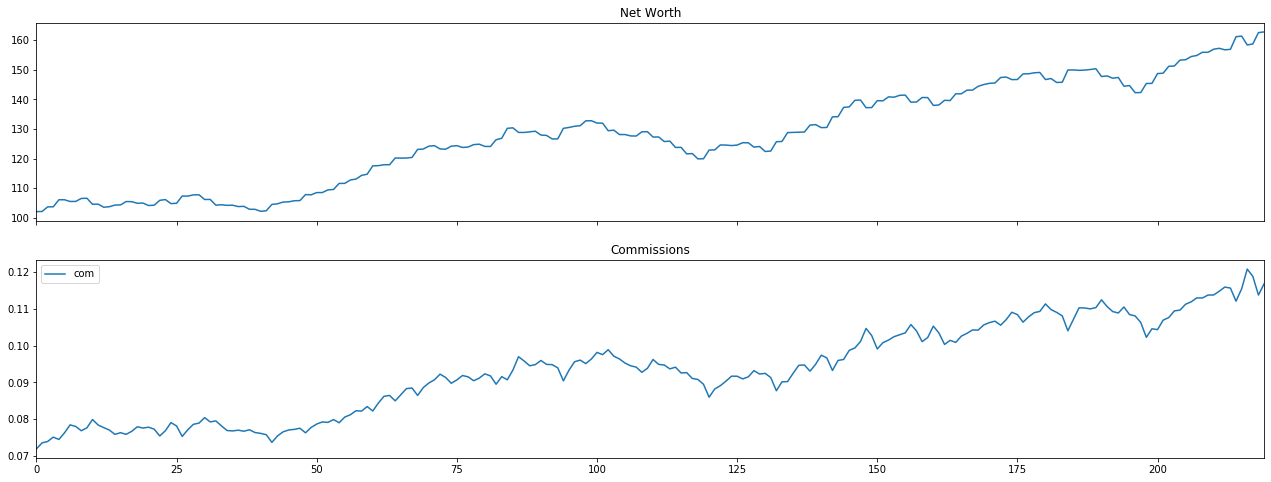

In [66]:
ax = plt.subplot(211)
exchange.performance.net_worth.plot(figsize=(22,8), label='net worth', title='Net Worth')
exchange.performance['com'] = exchange.trades.price*0.00075
ax2 = plt.subplot(212, sharex=ax)
exchange.performance.com.plot(title='Commissions')
plt.legend()

Index(['open', 'high', 'low', 'close', 'volume', 'momentum_rsi', 'adx',
       'adx_long', 'adx_pos', 'adx_neg', 'trend_ema_fast', 'trend_ema_slow'],
      dtype='object')


Text(0.5, 1.0, 'Wins:66 Losses:44 Win rate 60.0%')

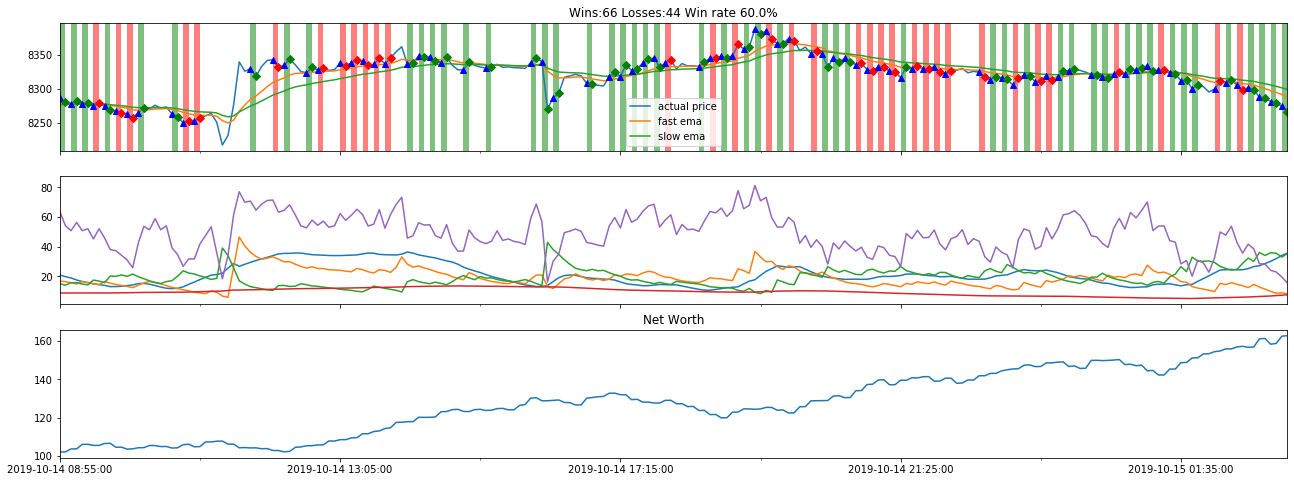

In [70]:
wins = 0
losses = 0 
ax = plt.subplot(311)

exchange._price_history.plot(figsize=(22,8), label='actual price')
print(_test_data.columns)
_test_data.trend_ema_fast.plot(label='fast ema')
_test_data.trend_ema_slow.plot(label='slow ema')

# print(exchange._price_history.head())
# print(exchange.trades.head())
# print(exchange.performance.head())
for idx,trade in exchange.trades.iterrows():
    price_at_trade = exchange._price_history[trade.step-1]
    if trade.type.is_buy:
        plt.plot(trade.step-1 , price_at_trade, "b^")
    elif trade.type.is_sell:
        the_buy_step = exchange.trades.iloc[idx-1]
        profit = trade.price - the_buy_step.price
        if profit < 0:
            losses +=1
            color = '#d62728'
            plt.axvspan(the_buy_step.step-1, trade.step-1, alpha= 0.5, facecolor='red')
            plt.plot(trade.step-1, price_at_trade, "rD")

        elif profit >= 0:
            wins +=1
            color = '#2ca02c'
            plt.axvspan(the_buy_step.step-1, trade.step-1, alpha= 0.5, facecolor='green')
            plt.plot(trade.step-1, price_at_trade, "gD")

adx = plt.subplot(312, sharex=ax)
_test_data.adx.plot(label='adx')
_test_data.adx_pos.plot(label='pos')
_test_data.adx_neg.plot(label='neg')
_test_data.adx_long.plot(label='long')

_test_data.momentum_rsi.plot(label='rsi')

ax2 = plt.subplot(313, sharex=adx)
exchange.performance.net_worth.plot(title='Net Worth')
ax.legend()

ax.set_title("Wins:{} Losses:{} Win rate {}%".format(wins, losses, round((wins/(wins+losses))*100, 4) ))


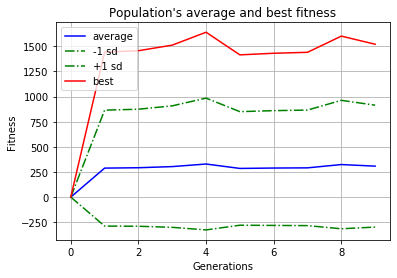

In [68]:
import visualize

visualize.plot_stats(stats, ylog=False, view=True)


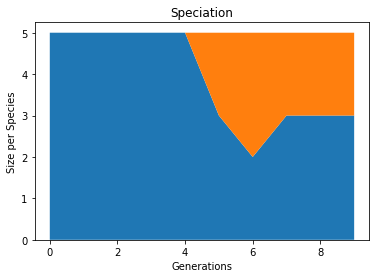

In [69]:
visualize.plot_species(stats, view=True)

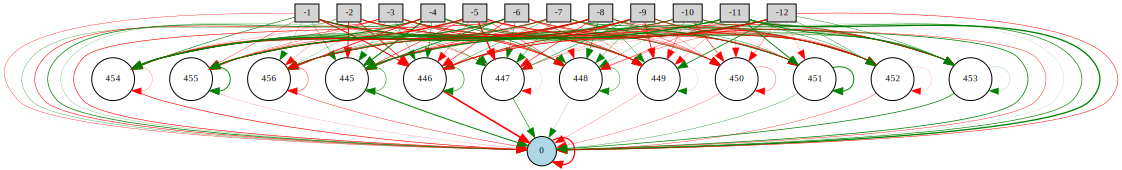

In [42]:
visualize.draw_net(strategy._config, winner, False)


**Save Strategy**

In [ ]:
# winner.key
with open("winners/winner-{}.bin".format(winner.key), "wb") as f:
    pickle.dump(winner, f, 2)
with open("winners/winner-{}_bak.bin".format(winner.key), "wb") as f:
    pickle.dump(winner, f, 2)